# Proceso ETL (Extracción, Transformación y Carga) — AquaBRYM

## 1) Importación de Librerías

In [17]:
import os
import numpy as np
import pandas as pd
import sqlalchemy as sa
import matplotlib.pyplot as plt
!pip install pymysql
import pymysql

pd.set_option('display.max_columns', 50)


## 2) Carga de Datos: Conexión a MySQL

In [7]:
# Credenciales (preferible por variables de entorno)
DB_USER = os.getenv("DB_USER", "root")
DB_PASS = os.getenv("DB_PASS", "1234")
DB_HOST = os.getenv("DB_HOST", "localhost")
DB_PORT = os.getenv("DB_PORT", "3306")
DB_NAME = os.getenv("DB_NAME", "aqua_db")

# Crea el engine SQLAlchemy (driver PyMySQL)
conn_str = f"mysql+pymysql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = sa.create_engine(conn_str, pool_pre_ping=True)

# Pequeña prueba de conexión
with engine.connect() as con:
    version = con.exec_driver_sql("SELECT VERSION()").scalar()
print("Conexión OK. MySQL versión:", version)


Conexión OK. MySQL versión: 9.1.0


## 3) Extracción desde la BD

In [8]:
# Puedes limitar filas con 'LIMIT' mientras pruebas
ENTITIES_Q = "SELECT id, name, address, entity_type, userId AS user_id, created_at, updated_at FROM entities;"
SENSORS_Q  = "SELECT id, sensor_type, model, installation_at, status, entityId AS entity_id, created_at, updated_at FROM sensors;"
READ_Q     = "SELECT id, timestamp, pulses, flow_rate_lpm, volume_liters, sensorId AS sensor_id, created_at FROM sensor_readings;"
ALERTS_Q   = "SELECT id, sensorId AS sensor_id, detected_at, description, level, resolved, resolved_at, extra_data FROM alerts;"
BILLS_Q    = "SELECT id, entityId AS entity_id, period_start, period_end, consumption_m3, rate_per_m3, fixed_charge, amount_due, issued_at, due_date, status, created_at, updated_at FROM bills;"
USERS_Q    = "SELECT id, email, role, created_at, updated_at FROM users;"

with engine.begin() as con:
    df_entities = pd.read_sql(ENTITIES_Q, con)
    df_sensors  = pd.read_sql(SENSORS_Q, con)
    df_readings = pd.read_sql(READ_Q, con)
    df_alerts   = pd.read_sql(ALERTS_Q, con)
    df_bills    = pd.read_sql(BILLS_Q, con)
    df_users    = pd.read_sql(USERS_Q, con)

print("Filas: entities", len(df_entities), "| sensors", len(df_sensors), "| readings", len(df_readings), "| alerts", len(df_alerts), "| bills", len(df_bills), "| users", len(df_users))


Filas: entities 101 | sensors 101 | readings 100 | alerts 106 | bills 100 | users 103


## 4) Creación del/los DataFrame(s) a Manipular

In [9]:
# Tipos de fecha
for col in ["timestamp", "created_at"]:
    if col in df_readings.columns:
        df_readings[col] = pd.to_datetime(df_readings[col], errors='coerce')

if "installation_at" in df_sensors.columns:
    df_sensors["installation_at"] = pd.to_datetime(df_sensors["installation_at"], errors='coerce')

for col in ["created_at","updated_at","period_start","period_end","issued_at","due_date"]:
    if col in df_bills.columns:
        df_bills[col] = pd.to_datetime(df_bills[col], errors='coerce')

# Merge: readings -> sensors (sensor_id)
df_rs = df_readings.merge(df_sensors.rename(columns={"id":"sensor_id"}), on="sensor_id", how="left")
# Merge: -> entities (entity_id)
df_rse = df_rs.merge(df_entities.rename(columns={"id":"entity_id"}), on="entity_id", how="left", suffixes=("_sensor","_entity"))

# Preview
df_rse.head()


,id,timestamp,pulses,flow_rate_lpm,volume_liters,sensor_id,created_at_x,sensor_type,model,installation_at,status,entity_id,created_at_y,updated_at_sensor,name,address,entity_type,user_id,created_at,updated_at_entity
0,1,2025-07-22 17:08:31,167,14.01,439.79,103,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2024-09-08,active,2,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,"Altenwerth, Howell and Harber",26904 Mozell Meadows,institution,101,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087
1,2,2025-07-22 17:11:03,148,11.78,45.77,102,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2025-06-07,inactive,3,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,Grant - Dach,56022 Weber Wells,institution,100,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087
2,3,2025-07-22 10:36:44,354,2.88,76.05,101,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2025-04-10,active,4,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,"Bogan, Homenick and Walker",9499 Harmon Mills,house,99,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087
3,4,2025-07-21 21:43:22,90,10.88,218.15,100,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2024-10-12,inactive,5,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,Wisozk - Hagenes,9524 Vicarage Road,institution,98,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087
4,5,2025-07-21 20:57:30,323,12.90,372.27,99,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2025-07-11,active,6,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,Maggio Group,30657 DuBuque Ports,house,97,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087


## 5) Análisis Exploratorio (EDA)

In [10]:
print("=== Info df_rse ===")
print(df_rse.info())

print("\n=== Nulos por columna ===")
print(df_rse.isna().sum().sort_values(ascending=False).head(20))

print("\n=== Duplicados (por id lectura) ===")
dup_count = df_rse.duplicated(subset=['id']).sum() if 'id' in df_rse.columns else df_rse.duplicated().sum()
print("Duplicados:", dup_count)

print("\n=== Describe numérico ===")
display(df_rse.select_dtypes(include=['number']).describe())

print("\n=== Top entidades por volumen total (litros) ===")
if "volume_liters" in df_rse.columns and "entity_id" in df_rse.columns:
    top_entities = df_rse.groupby("entity_id")["volume_liters"].sum().sort_values(ascending=False).head(10)
    display(top_entities)


=== Info df_rse ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 100 non-null    int64         
 1   timestamp          100 non-null    datetime64[ns]
 2   pulses             100 non-null    int64         
 3   flow_rate_lpm      100 non-null    float64       
 4   volume_liters      100 non-null    float64       
 5   sensor_id          100 non-null    int64         
 6   created_at_x       100 non-null    datetime64[ns]
 7   sensor_type        100 non-null    object        
 8   model              100 non-null    object        
 9   installation_at    100 non-null    datetime64[ns]
 10  status             100 non-null    object        
 11  entity_id          100 non-null    int64         
 12  created_at_y       100 non-null    datetime64[ns]
 13  updated_at_sensor  100 non-null    datetime64[

,id,pulses,flow_rate_lpm,volume_liters,sensor_id,entity_id,user_id
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,50.500000,251.760000,10.920300,241.573300,53.500000,51.500000,51.500000
std,29.011492,125.537802,5.739155,145.289748,29.011492,29.011492,29.011492
min,1.000000,50.000000,1.040000,14.120000,4.000000,2.000000,2.000000
25%,25.750000,146.750000,5.885000,115.667500,28.750000,26.750000,26.750000
50%,50.500000,252.000000,10.920000,242.890000,53.500000,51.500000,51.500000
75%,75.250000,354.000000,15.652500,367.405000,78.250000,76.250000,76.250000
max,100.000000,492.000000,19.960000,494.800000,103.000000,101.000000,101.000000



=== Top entidades por volumen total (litros) ===


entity_id
67    494.80
64    490.45
21    484.64
77    482.83
42    480.03
62    479.66
86    462.67
94    449.03
56    440.01
2     439.79
Name: volume_liters, dtype: float64

## 6) Limpieza de Datos

In [11]:
df = df_rse.copy()

# Ejemplo: imputación sencilla de flow_rate_lpm con mediana por sensor
if "flow_rate_lpm" in df.columns:
    df["flow_rate_lpm"] = df.groupby("sensor_id")["flow_rate_lpm"].transform(
        lambda s: s.fillna(s.median())
    )

# volume_liters nulos -> 0 (si aplica a tu lógica)
if "volume_liters" in df.columns:
    df["volume_liters"] = df["volume_liters"].fillna(0)

# Eliminar duplicados por id de lectura
if "id" in df.columns:
    before = len(df)
    df = df.drop_duplicates(subset=["id"])
    print(f"Duplicados eliminados: {before - len(df)}")

# Derivados de fecha
if "timestamp" in df.columns:
    df["date"] = pd.to_datetime(df["timestamp"], errors='coerce').dt.date
    df["hour"] = pd.to_datetime(df["timestamp"], errors='coerce').dt.hour

print("Shape limpio:", df.shape)
df.head()


Duplicados eliminados: 0
Shape limpio: (100, 22)


,id,timestamp,pulses,flow_rate_lpm,volume_liters,sensor_id,created_at_x,sensor_type,model,installation_at,status,entity_id,created_at_y,updated_at_sensor,name,address,entity_type,user_id,created_at,updated_at_entity,date,hour
0,1,2025-07-22 17:08:31,167,14.01,439.79,103,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2024-09-08,active,2,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,"Altenwerth, Howell and Harber",26904 Mozell Meadows,institution,101,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087,2025-07-22,17
1,2,2025-07-22 17:11:03,148,11.78,45.77,102,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2025-06-07,inactive,3,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,Grant - Dach,56022 Weber Wells,institution,100,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087,2025-07-22,17
2,3,2025-07-22 10:36:44,354,2.88,76.05,101,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2025-04-10,active,4,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,"Bogan, Homenick and Walker",9499 Harmon Mills,house,99,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087,2025-07-22,10
3,4,2025-07-21 21:43:22,90,10.88,218.15,100,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2024-10-12,inactive,5,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,Wisozk - Hagenes,9524 Vicarage Road,institution,98,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087,2025-07-21,21
4,5,2025-07-21 20:57:30,323,12.90,372.27,99,2025-07-22 19:22:37.612778,flow_turbina,YF-S201,2025-07-11,active,6,2025-07-22 19:22:37.566245,2025-07-22 19:22:37.566245,Maggio Group,30657 DuBuque Ports,house,97,2025-07-22 19:22:37.526087,2025-07-22 19:22:37.526087,2025-07-21,20


## 7) Visualización de Datos (2 a 5 gráficas)

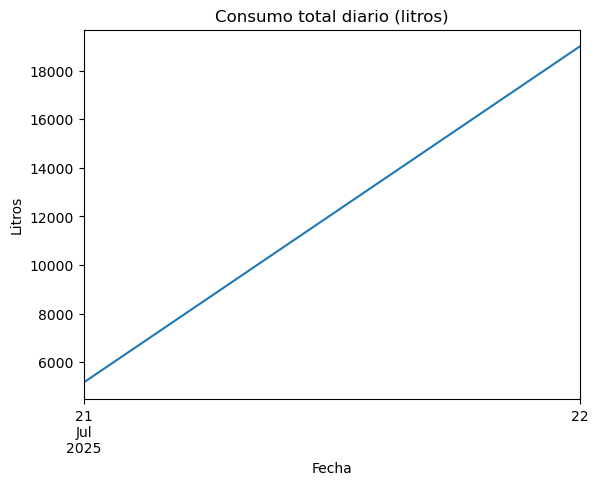

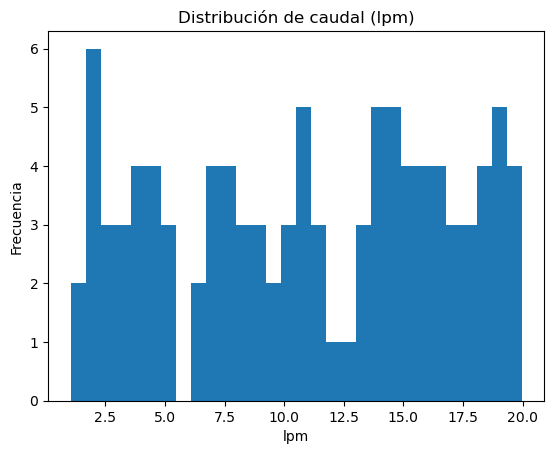

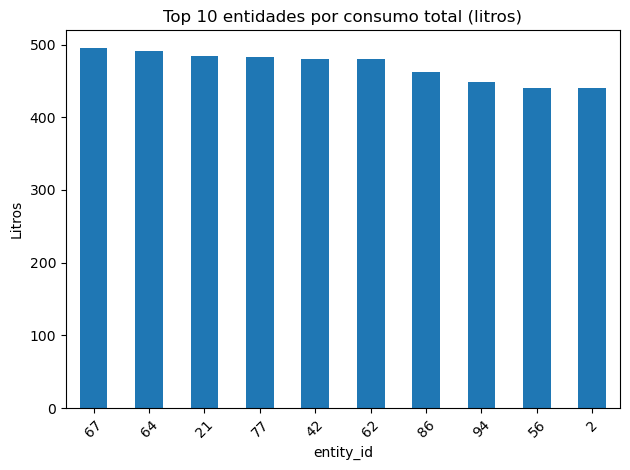

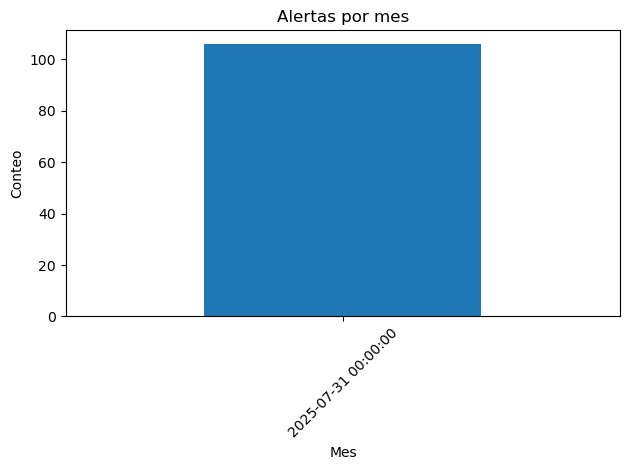

In [14]:
# 7.1 Serie temporal de consumo diario total (litros)
if {"volume_liters","timestamp"}.issubset(df.columns):
    daily = df.set_index(pd.to_datetime(df["timestamp"], errors='coerce')).resample('D')["volume_liters"].sum()
    plt.figure()
    daily.plot()
    plt.title("Consumo total diario (litros)")
    plt.xlabel("Fecha")
    plt.ylabel("Litros")
    plt.show()

# 7.2 Histograma de caudal (lpm)
if "flow_rate_lpm" in df.columns:
    plt.figure()
    df["flow_rate_lpm"].dropna().plot(kind="hist", bins=30)
    plt.title("Distribución de caudal (lpm)")
    plt.xlabel("lpm")
    plt.ylabel("Frecuencia")
    plt.show()

# 7.3 Top 10 entidades por volumen total
if {"entity_id","volume_liters"}.issubset(df.columns):
    top10 = df.groupby("entity_id")["volume_liters"].sum().sort_values(ascending=False).head(10)
    plt.figure()
    top10.plot(kind="bar")
    plt.title("Top 10 entidades por consumo total (litros)")
    plt.xlabel("entity_id")
    plt.ylabel("Litros")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 7.4 Alertas por mes
if not df_alerts.empty:
    alerts = df_alerts.copy()
    alerts["detected_at"] = pd.to_datetime(alerts["detected_at"], errors='coerce')
    monthly_alerts = alerts.set_index("detected_at").resample("ME")["id"].count() if "id" in alerts.columns else alerts.set_index("detected_at").resample("M").size()
    plt.figure()
    monthly_alerts.plot(kind="bar")
    plt.title("Alertas por mes")
    plt.xlabel("Mes")
    plt.ylabel("Conteo")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## 8) Exportación del Data Set (.csv)

In [16]:
OUTPUT_PATH = r"C:\Users\BraytoGBDX\Desktop\dataset_clean.csv"
df.to_csv(OUTPUT_PATH, index=False, encoding="utf-8")
print("Archivo exportado:", OUTPUT_PATH)


Archivo exportado: C:\Users\BraytoGBDX\Desktop\dataset_clean.csv
